In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np

In [52]:
# %connect_info
# %qtconsole

Import data from csv fies

In [40]:
from graphgym.custom_graphgym.loader.protein import ProteinBatchDataset
# dataset = ProteinBatchDataset("../data/yeast-ORBI", numeric_params=['protein probability'])
# dataset = ProteinBatchDataset("../data/yeast-LCQ", numeric_params=['protein probability'])
# dataset = ProteinBatchDataset("../data/yeast-ORBI-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
# dataset = ProteinBatchDataset("../data/yeast-LCQ-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
dataset = ProteinBatchDataset("../data/single", numeric_params=['protein.score'])

In [41]:
dataset.x

tensor([[417.5766],
        [247.0453],
        [ 31.5360],
        ...,
        [ 22.8700],
        [ 22.1998],
        [ 59.6527]])

In [42]:
dataset.y[dataset.train_mask].bincount()
dataset.y[dataset.val_mask].bincount()
dataset.y[dataset.test_mask].bincount()

tensor([ 676, 1694])

tensor([ 91, 205])

tensor([ 97, 199])

In [48]:
# print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of node features: {dataset.num_node_features}')
# print(f'Number of edges: {dataset.num_edges}')
print(f'Number of edge features: {dataset.num_edge_features}')
# print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Number of training nodes: {dataset.train_mask.sum()}')
# print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Validation node label rate: {int(dataset.val_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Test node label rate: {int(dataset.test_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
# print(f'Has self-loops: {dataset.has_self_loops()}')
# print(f'Is undirected: {dataset.is_undirected()}')

Number of node features: 1
Number of edge features: 0
Number of training nodes: 2370


In [49]:
dataset

ProteinBatchDataset()

In [50]:
from torch.utils.data import DataLoader
import torch
train_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.train_mask], dataset.y[dataset.train_mask])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.val_mask], dataset.y[dataset.val_mask])
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.test_mask], dataset.y[dataset.test_mask])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [51]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


# define the LightningModule
class MLP(pl.LightningModule):
    def __init__(self, num_features, hidden_channels, num_classes, criterion):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, num_classes)
        self.criterion = criterion
        self.val_auroc = BinaryAUROC()
        self.test_auroc = BinaryAUROC()
        self.val_accuracy = BinaryAccuracy()
        self.test_accuracy = BinaryAccuracy()
        self.val_F1 = BinaryF1Score()
        self.test_F1 = BinaryF1Score()

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        return x

    def get_auc(self, out, target):
        return self.auroc(torch.sigmoid(out)[:, 1], target)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        values = {"loss": loss}
        self.log_dict(values, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        self.val_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        self.val_auroc.update(logits[:, 1], y)
        self.val_F1.update(logits[:, 1], y)
        values = {"val_loss": loss, "val_acc": self.val_accuracy, "val_auc": self.val_auroc, 'val_F1': self.val_F1}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.test_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)
        self.test_auroc.update(logits[:, 1], y)
        self.test_F1.update(logits[:, 1], y)
        values = {"test_loss": loss, "test_acc": self.test_accuracy, "test_auc": self.test_auroc, 'test_F1': self.test_F1}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer





In [52]:
# init the autoencoder
MLP_model = MLP(dataset.num_node_features, 10, 2, criterion = torch.nn.CrossEntropyLoss())

In [53]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=100, enable_progress_bar = False)
trainer.fit(model=MLP_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | lin1          | Linear           | 20    
1 | lin2          | Linear           | 110   
2 | lin3          | Linear           | 22    
3 | criterion     | CrossEntropyLoss | 0     
4 | val_auroc     | BinaryAUROC      | 0     
5 | test_auroc    | BinaryAUROC      | 0     
6 | val_accuracy  | BinaryAccuracy   | 0     
7 | test_accuracy | BinaryAccuracy   | 0     
8 | val_F1        | BinaryF1Score    | 0     
9 | test_F1       | BinaryF1Score    | 0     
---------------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_c

In [54]:
trainer.test(model=MLP_model, dataloaders=test_dataloader)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_F1            0.8040404319763184
        test_acc            0.6722972989082336
        test_auc             0.681500256061554
        test_loss           0.6272255182266235
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[{'test_loss': 0.6272255182266235,
  'test_acc': 0.6722972989082336,
  'test_auc': 0.681500256061554,
  'test_F1': 0.8040404319763184}]

In [27]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...

In [65]:
from torch_geometric.nn import GCNConv
import torch_geometric.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        # self.batch_norm1 = nn.BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        # self.batch_norm2 = nn.BatchNorm(hidden_channels)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        # use batchnorm instead of dropout
        x = F.dropout(x, p=0.5, training=self.training)
        # x = self.batch_norm1(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
print(model)

In [66]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# uncomment for first time run
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=30, alpha=0.5, c=color, cmap="Set2")
    plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | lin1 | Linear | 20    
1 | lin2 | Linear | 110   
2 | lin3 | Linear | 22    
--------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
/Users/guchunhui/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/guchunhui/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUs

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 2)
)

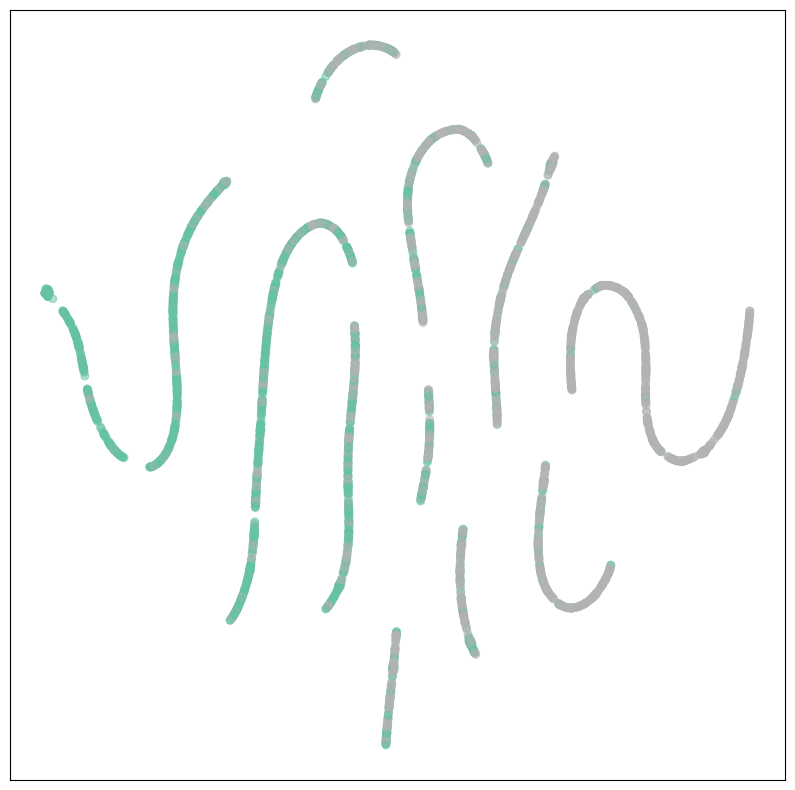

In [35]:
model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

In [36]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=10, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x, dataset.edge_index)  # Perform a single forward pass.
      train_loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[dataset.train_mask] == dataset.y[dataset.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(dataset.train_mask.sum())
      train_loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return float(train_loss.detach()), train_acc


def val():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      val_loss = criterion(out[dataset.val_mask], dataset.y[dataset.val_mask])
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[dataset.val_mask] == dataset.y[dataset.val_mask] # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(dataset.val_mask.sum())  # Derive ratio of correct predictions.
      return float(val_loss.detach()), val_acc

def test():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 101):
    train_loss, train_acc = train()
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss, val_acc = val()
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f} Train acc: {train_acc:.4f} '
          f'Validation loss: {val_loss: .4f}, Validation acc: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train loss: 0.7060 Train acc: 0.5572 Validation loss:  0.7046, Validation acc: 0.5218
Epoch: 002, Train loss: 0.6993 Train acc: 0.5561 Validation loss:  0.6987, Validation acc: 0.5218
Epoch: 003, Train loss: 0.6966 Train acc: 0.5541 Validation loss:  0.6932, Validation acc: 0.5218
Epoch: 004, Train loss: 0.6908 Train acc: 0.5551 Validation loss:  0.6880, Validation acc: 0.6589
Epoch: 005, Train loss: 0.6879 Train acc: 0.6616 Validation loss:  0.6832, Validation acc: 0.7290
Epoch: 006, Train loss: 0.6844 Train acc: 0.6830 Validation loss:  0.6786, Validation acc: 0.6947
Epoch: 007, Train loss: 0.6807 Train acc: 0.6476 Validation loss:  0.6744, Validation acc: 0.6604
Epoch: 008, Train loss: 0.6784 Train acc: 0.6242 Validation loss:  0.6706, Validation acc: 0.6526
Epoch: 009, Train loss: 0.6753 Train acc: 0.6029 Validation loss:  0.6670, Validation acc: 0.6480
Epoch: 010, Train loss: 0.6716 Train acc: 0.5941 Validation loss:  0.6637, Validation acc: 0.6495
Epoch: 011, Train lo

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

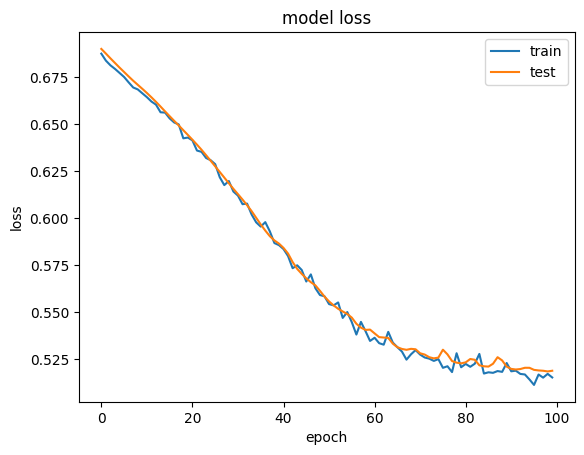

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'acc')

Text(0.5, 0, 'epoch')

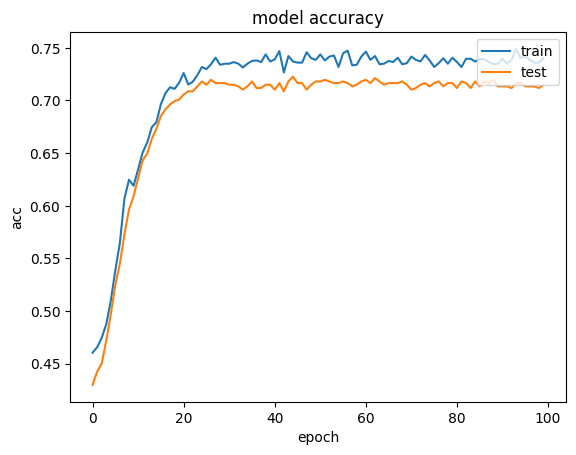

In [108]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [1]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

NameError: name 'test' is not defined

GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 2)
)

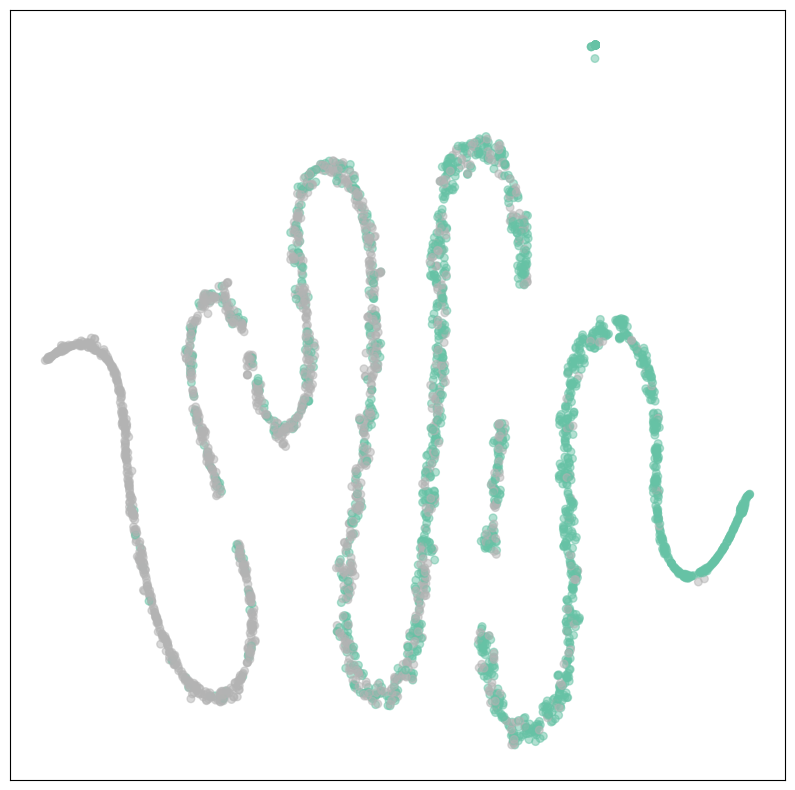

In [37]:
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

In [32]:
# when dataset contain two graph
# to-do create dataset class


# need good standardization to generalize to model to different spices and experiment conditions
# semi-supervise
# transfer learning


# the performance is not good
# need to include more nodes features: protein characteristics, ...
# more ideal not use calculated protein score, instead use variables used to calculate protein score directly



# GPU resource